# Part 1 - NetworkX

In [12]:
import pandas as pd
import numpy as np
import networkx as nx

df = pd.read_parquet('ner_predictions_v2.parquet')
#df['entities'] = df['entities'].apply(lambda x: eval(x))

In [13]:
df.loc[0, 'entities']

{'academic_background': {'dates': array(['2013'], dtype=object),
  'degrees': array(['Design'], dtype=object),
  'locations': array(['U. K.'], dtype=object),
  'universities': array(['Camberwell College of Arts UAL'], dtype=object)},
 'academic_experience': {'dates': array([], dtype=object),
  'degrees': array([], dtype=object),
  'locations': array([], dtype=object),
  'universities': array([], dtype=object)},
 'corporate_experience': {'companies': array(['A & M Studio', 'Becquerel Capital'], dtype=object),
  'dates': array(['2023', '2017 – 2023', '2014 – 2017', '2013 – 2014'], dtype=object),
  'locations': array(['Spain', 'V', '##idivixi', 'Mexico', 'Mexico', 'The Hub',
         'Hong Kong'], dtype=object)}}

In [14]:
G = nx.Graph()

for _, row in df.iterrows():
    prof = row["alias"]
    G.add_node(prof, type="Professor")

    info = row["entities"]

    # corporate experience
    for company in info['corporate_experience']['companies']:
        G.add_node(company, type="Company")
        G.add_edge(prof, company, relation="worked_at")
    for location in info['corporate_experience']['locations']:
        G.add_node(location, type="Location")
        G.add_edge(prof, location, relation="worked_in")
    for date in info['corporate_experience']['dates']:
        G.add_node(date, type="Date")
        G.add_edge(prof, date, relation="worked_during")

    # academic_experience
    for university in info['academic_experience']['universities']:
        G.add_node(university, type="University")
        G.add_edge(prof, university, relation="professor_at")
    for degree in info['academic_experience']['degrees']:
        G.add_node(degree, type="Degree")
        G.add_edge(prof, degree, relation="professor_of")
    for location in info['academic_experience']['locations']:
        G.add_node(location, type="Location")
        G.add_edge(prof, location, relation="professor_in")
    for date in info['academic_experience']['dates']:
        G.add_node(date, type="Date")
        G.add_edge(prof, date, relation="professor_during")

    # academic_background
    for university in info['academic_background']['universities']:
        G.add_node(university, type="University")
        G.add_edge(prof, university, relation="studied_at")
    for degree in info['academic_background']['degrees']:
        G.add_node(degree, type="Degree")
        G.add_edge(prof, degree, relation="student_of")
    for location in info['academic_background']['locations']:
        G.add_node(location, type="Location")
        G.add_edge(prof, location, relation="studied_in")
    for date in info['academic_background']['dates']:
        G.add_node(date, type="Date")
        G.add_edge(prof, date, relation="studied_during")




In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_graph(G, top_n=80, layout_seed=42):
    """
    Visualize a filtered knowledge graph using betweenness or eigenvector centrality,
    with color coding, node sizing, and a legend.

    Parameters
    ----------
    G : nx.Graph
        The full graph.
    top_n : int
        Number of most central nodes to visualize.
    layout_seed : int
        Random seed for reproducibility.
    """

    # --- Compute centrality measure ---
    centrality = nx.betweenness_centrality(G)
    

    # --- Filter top nodes by centrality ---
    top_nodes = sorted(centrality, key=centrality.get, reverse=True)[:top_n]
    G_filtered = G.subgraph(top_nodes).copy()

    # --- Set up node colors and sizes ---
    color_map = []
    size_map = []
    for node, data in G_filtered.nodes(data=True):
        node_type = data.get("type", "Other")

        # Assign colors by node type
        if node_type == "Professor":
            color = "#66b3ff"  # blue
        elif node_type == "University":
            color = "#7dce82"  # green
        elif node_type == "Company":
            color = "#f4a261"  # orange
        elif node_type == "Location":
            color = "#e76f51"  # red
        elif node_type == "Degree":
            color = "#b56576"  # pink
        elif node_type == "Date":
            color = "#6d597a"  # purple
        else:
            color = "#999999"  # gray

        color_map.append(color)

        # Node size proportional to centrality
        importance = centrality.get(node, 0)
        size_map.append(400 + (importance * 3000))

    # --- Layout and draw ---
    plt.figure(figsize=(14, 12))
    pos = nx.spring_layout(G_filtered, k=0.5, seed=layout_seed)

    nx.draw_networkx_nodes(G_filtered, pos, node_color=color_map, node_size=size_map, alpha=0.9)
    nx.draw_networkx_edges(G_filtered, pos, alpha=0.4)
    nx.draw_networkx_labels(G_filtered, pos, font_size=8, font_weight="bold")

    # --- Edge labels (optional) ---
    edge_labels = nx.get_edge_attributes(G_filtered, "relation")
    nx.draw_networkx_edge_labels(G_filtered, pos, edge_labels=edge_labels, font_size=7, label_pos=0.5)

    # --- Create legend ---
    legend_patches = [
        mpatches.Patch(color="#66b3ff", label="Professor"),
        mpatches.Patch(color="#7dce82", label="University"),
        mpatches.Patch(color="#f4a261", label="Company"),
        mpatches.Patch(color="#e76f51", label="Location"),
        mpatches.Patch(color="#b56576", label="Degree"),
        mpatches.Patch(color="#6d597a", label="Date"),
        mpatches.Patch(color="#999999", label="Other"),
    ]
    plt.legend(handles=legend_patches, loc="lower left", fontsize=9, frameon=True, title="Node Type")

    plt.title(
        f"Knowledge Graph (Betweenness Centrality) — Top {top_n} Nodes",
        fontsize=14,
        fontweight="bold",
    )
    plt.axis("off")
    plt.show()



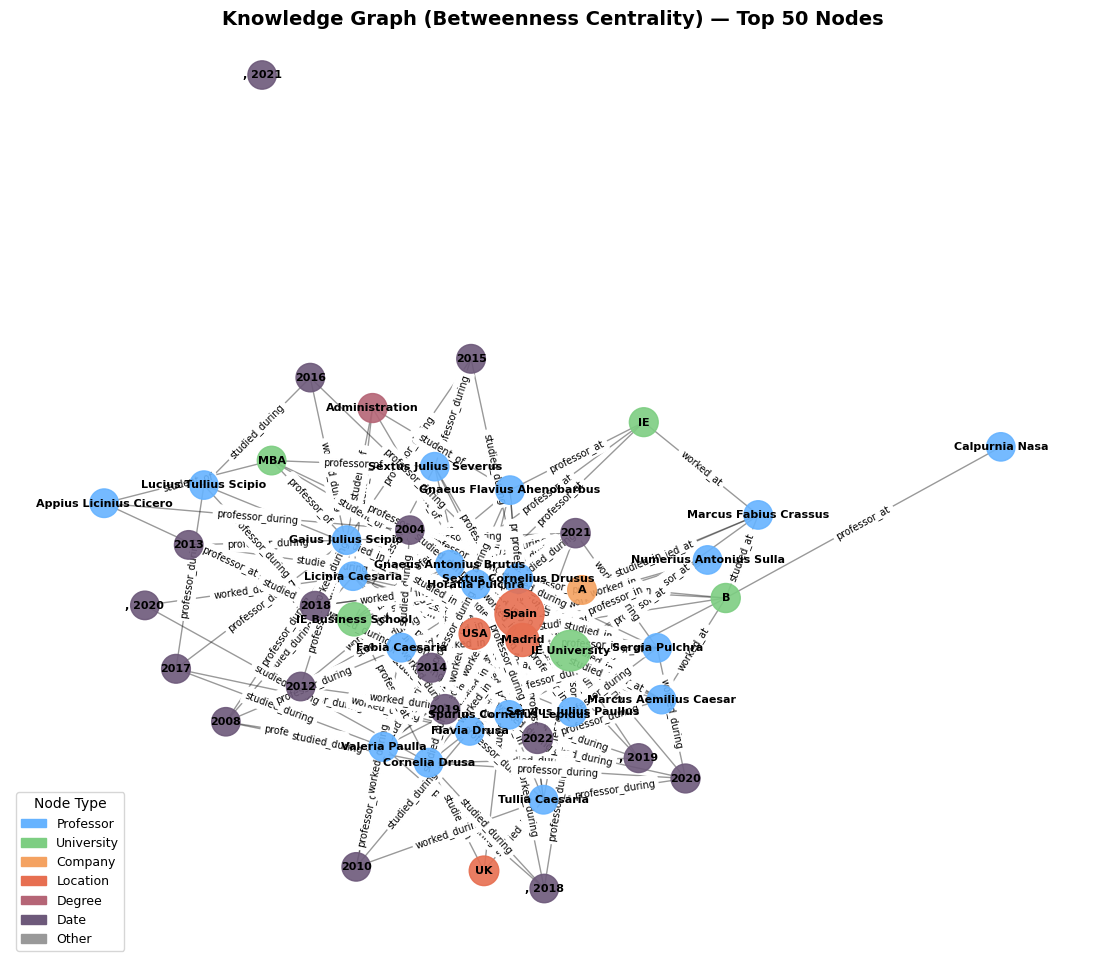

In [17]:
visualize_graph(G, top_n=50, layout_seed=42)